# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Цель исследования** будет состоять из следующих пунктов:
1. Зависит ли цена на недвижимость от каких-либо факторов.
2. Определить характеристики наиболее популярных объектов недвижимости.
3. Узнать средний срок продажи недвижимости.
4. Определить зависимость стоимости недвижимости от ее местонахождения

**Ход исследования**

Данные о поведении пользователей находятся в файле `real_estate_data.csv`. О качестве данных ничего не известно. Поэтому перед  исследованием понадобится провести обзор данных.

На этапе предобработки данных надо будет устранить явные и неявные дубликаты везде, где это возможно, и описать ситуации ,когда это невозможно. Проанализировать тип данных и изменить их, если потребуется(или изменить их чуть позже в зависимости от ситуации)

Следующим пунктом будет добавление новых столбцов в таблицу для дальнейших рачетов и нахождения зависимостей.

И финальным будет исследовательский анализ с выявлением закономерностей, построением графиков и создание соответствующих выводов.
Таким образом, исследование пройдёт в три этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Добавление в таблицу новых столбцов
 4. Исследовательский анализ данных
 5. Вывод

## Изучение общей информации. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')


In [3]:
data.info() #Получаем информацию о столбцах, количестве данных в них и их тип

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

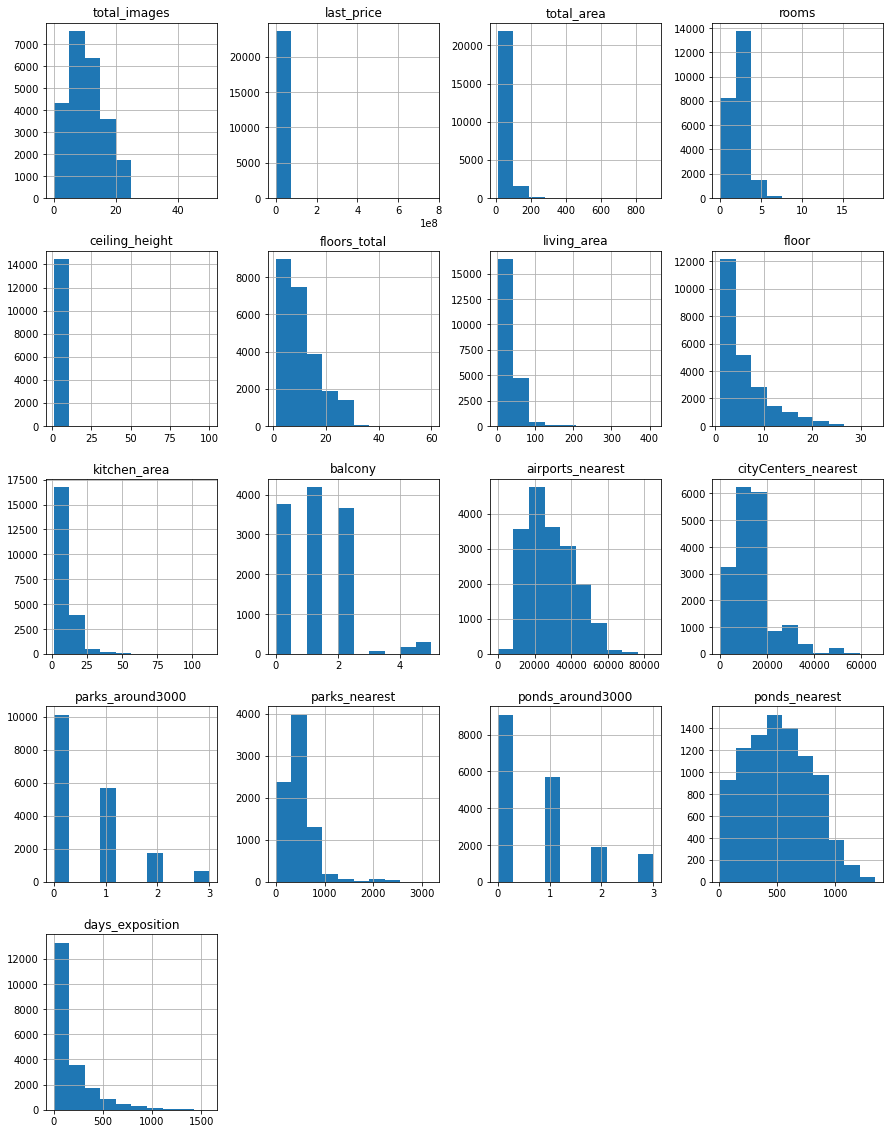

In [4]:
data.hist(figsize=(15, 20));

Построили таблицы по первоначальным данным, сразу же видны выбросы(например, график 'ceiling_height' из-за нескольких выбросов(предварительно) оказался полностью смещен в левую сторону.

## Предобработка данных

In [5]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

После подсчета видно количество пропусков в отдельных столбцах датафрейма. Поэтому дальше мы будем заменять пропуски различными значениями(например, как правило, пропуски в количественных значениях будут заменяться медианными(потому что в данных есть выбросы, которые сместят среднее значение))

In [6]:
data.duplicated().sum()

0

Видим, что явных дубликатов нет

Заполним пропуски медианным значением.

*Примечание.* Да, я видел, что рекомендуется принять значения 32 метров как 3.2 и так далее (можно было заменить значения, поделив их на 10 в случаях, когда высота потолков выше 5 метров, например), но мне не понравилась эта идея, так как в датафрейме мы видим в графе "max" максимальные значения как 900 квадратных метров площади, высота в 100 метров, жилая площадь в 409  квадратных метров и т.п. Скорее всего, это какой-то дворец и вряд ли там ошибка в каждом пункте. Поэтому есть вероятность, что такие объекты - не ошибка в данных, а исключения, поэтому я принял решение оставить все как есть(тем более, что таких значений 37, что составляет 0.15 % от всех данных)

Помимо этого, здесь и далее я придерживаюсь следующей логики: сначала идет заполнение всех пропущенных значений, после этого - срезы и т.д. Делается это для того, чтобы значения были максимально точны(если я с самого сначала буду отбрасывать значения, начиная с 1 стоблца, может получиться, что в последнем данные будут существенно отличаться от тех, которые могли получиться, если бы я не отбрасывал никаких значений. Поэтому сначала заполнение пропусков, потом - устранение аномалий и выбросов)

In [7]:
data['floors_total'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 33., 34., 35., 36., 37., 52., 60., nan])

Может быть, пропуски образовались в однотажных домах или из-за какой-то ошибки. Попробуем сгруппировать пропущенные данные по столбцу 'floor' и заполнить их медианным значением. Так, например, если пропуски действительно были из-за одноэтажных домов, верные значения вернутся на свое место.

In [8]:
data_transformed = data.groupby('floor')['floors_total'].transform('median')
data['floors_total'] = data['floors_total'].fillna(data_transformed)
data['floors_total'] = data['floors_total'].astype(int)

Пропуски устранены, данные переведены в формат int, так как дробного количества этажей быть не может.

In [9]:
data_transformed = data['living_area'].median() 
data['living_area'] = data['living_area'].fillna(data_transformed)  #Заполняем пропуски медианным значением

In [10]:
data_transformed = data['kitchen_area'].median()
data['kitchen_area'] = data['kitchen_area'].fillna(data_transformed)

In [11]:
data_transformed = data['airports_nearest'].median()
data['airports_nearest'] = data['airports_nearest'].fillna(data_transformed)

In [12]:
data_transformed = data['cityCenters_nearest'].median()
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data_transformed)

In [13]:
data['is_apartment'].unique()
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'] = data['is_apartment'].astype(bool)

Логично предположить, что люди, сдающие апартаменты, специально обозначали это, поэтому все пропуски заменим на False.

Так как в столбце 'is_apartment' мы определяем, является ли помещение апартаменом или нет, переводим после заполнения пропусков его в булевой тип.

In [14]:
display(data['balcony'].unique())
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype(int)

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

Видим, что есть пропуски в данных, заменяем пропущенные значения = 0, так как скорее всего, люди, заполнявшие данные, не отмечали балконы, если их нет(аналогично ситуации с апартаментами)

In [15]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].astype(int)

Аналогично, если бы парки были, их бы указали

In [16]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].astype(int)

Так как в столбце 'ponds_nearest' пропущено около 70% значений, заменять их медианой или еще каким-то значением нецелесообразно. Как видно на первоначальной гистограмме 'ponds_nearest', медиана находится где-то на уровне в 500 метров. А на графике 'ponds_around3000' большее число значений приходится на 0, что означает, что в пределах 3км нет никаких водоемов. Замена на медиану или среднее приведет к искажению данных. 

Аналогично с парками в 'parks_nearest'

In [17]:
data = data.dropna(subset=['locality_name']) #Избавляемся от пропусков, так как здесь их невозможно исправить

In [18]:
import warnings
warnings.filterwarnings('ignore')
for locality_name in data['locality_name'].unique():
    median = data.loc[data['locality_name'] == locality_name, 'ceiling_height'].median()
    data.loc[(data['ceiling_height'].isna()) & (data['locality_name'] == locality_name), 'ceiling_height'] = median
    
median_ceiling_height = data['ceiling_height'].median()
display(median_ceiling_height) # было 2.65
data['ceiling_height'] = data['ceiling_height'].fillna(median_ceiling_height)
data[data['ceiling_height'] >= 5]['ceiling_height'].count() #было 37

2.7

41

In [19]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [20]:
data['locality_name'] = data['locality_name'].str.replace('поселок', 'посёлок')
data['locality_name'] = data['locality_name'].str.replace('городской посёлок', 'посёлок городского типа')
data['locality_name'] = data['locality_name'].str.replace('при железнодорожной ', '')

В столбце 'locality_name' было замечено много различий, такие как наличие "поселков" и "посёлков", посёлков "станции" и "при железнодорожной станции", поэтому было решено изменить данные для более простого выявления неявных дубликатов.

In [21]:
def change_name(names):
    for name in names:
        for city in data['locality_name']:
            if name in city:
                data['locality_name'] = data['locality_name'].str.replace(city, 'посёлок ' + name)
    return data['locality_name']      
names = ['Янино-1', 'Большая Ижора', 'Лесогорский', 'Мга', 'Назия', 'Павлово', 'Рощино', 'Советский', 'Фёдоровское']
data['locality_name'] = change_name(names)
data['locality_name'] = data['locality_name'].replace('посёлок Фёдоровское', 'посёлок городского типа Фёдоровское')

Были замечены несколько населенных пунктов, фигурировавших в нескольких местах сразу, поэтому было принято решение переименовать их в что-то одно. Исключение - посёлок городского типа Фёдоровское, так как остальные как были посёлками, так ими и остались.

In [22]:
data['days_exposition'].unique()

array([  nan,   81.,  558., ..., 1360., 1007.,  971.])

In [23]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest            0
cityCenters_nearest         0
parks_around3000            0
parks_nearest           15586
ponds_around3000            0
ponds_nearest           14565
days_exposition          3180
dtype: int64

Итак, после удаления большей части пропусков мы знаем, что пропуски остались в 3 столбцах: "ponds_nearest", "parks_nearest" и "days_exposition".
Насчет первого и второго писал выше, поэтому сейчас о "days_exposition". В этом столбце находится количество дней, за которые объект продали. Логично предположить, что если этого значения нет, то объект все еще в продаже, поэтому изменение может серьезно повлиять на данные.

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  int32  
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  int32  
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

## Добавление в таблицу новых столбцов

In [25]:
data['price_sq_meter'] = data['last_price'] / data['total_area'] # Узнаем цену за квадратный метр

In [26]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition']) #Переводим в datetime

In [27]:
data['day'] = data['first_day_exposition'].dt.weekday #Узнаем день недели, когда был выложен объект(0-понедельник и тд)

In [28]:
data['month'] = data['first_day_exposition'].dt.month #Узнаем месяц, когда был выложен объект

In [29]:
data['year'] = data['first_day_exposition'].dt.year #Узнаем год, когда был выложен объект

In [30]:
def determinate_type(row): #Определяем тип этажа
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

data['type_floor'] = data.apply(determinate_type, axis=1)

In [31]:
data['cityCenter_km'] = round(data['cityCenters_nearest'] / 1000) #округляем расстояние до центра города
data['cityCenter_km'] = data['cityCenter_km'].astype(int) #И переводим столбец в целочисленный формат(округлили же)

## Исследовательский анализ данных

#### Окончательная обработка данных

Хоть название раздела и гласит "исследовательский анализ данных", сначала будет происходить то, о чем писалось раньше, а именно "отбрасывание хвостов", а уже потом - анализ.

In [32]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sq_meter,day,month,year,cityCenter_km
count,23650.000000,2.365000e+04,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,...,23650.000000,8064.000000,23650.000000,9085.000000,20470.000000,2.365000e+04,23650.000000,23650.000000,23650.000000,23650.000000
mean,9.862326,6.541127e+06,60.329069,2.070106,2.733775,10.684059,34.091359,5.893277,10.425715,0.591712,...,0.469091,490.830729,0.590359,518.059879,180.753200,9.943225e+04,2.568710,6.401564,2017.370021,13.913911
std,5.682278,1.089640e+07,35.661808,1.078620,1.010372,6.597081,21.169359,4.883317,5.628088,0.959662,...,0.748458,342.554386,0.883539,277.841733,219.777916,5.033794e+04,1.788808,3.491418,1.037806,7.561217
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,...,0.000000,1.000000,0.000000,13.000000,1.000000,1.118349e+02,0.000000,1.000000,2014.000000,0.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.550000,5.000000,19.000000,2.000000,7.300000,0.000000,...,0.000000,288.000000,0.000000,293.000000,45.000000,7.661497e+04,1.000000,3.000000,2017.000000,11.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.700000,9.000000,30.000000,4.000000,9.100000,0.000000,...,0.000000,454.500000,0.000000,502.000000,95.000000,9.500000e+04,3.000000,6.000000,2017.000000,13.000000
75%,14.000000,6.799000e+06,69.700000,3.000000,2.700000,16.000000,41.037500,8.000000,11.427500,1.000000,...,1.000000,612.000000,1.000000,730.000000,231.000000,1.142742e+05,4.000000,10.000000,2018.000000,15.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,...,3.000000,3190.000000,3.000000,1344.000000,1580.000000,1.907500e+06,6.000000,12.000000,2019.000000,66.000000


Наверное, стоит пояснить, что происходит ниже. С помощью графика размаха(boxplot-а) мы можем видеть, где находится большая часть значений, а так же, где находятся "усы". Соответсвенно, отходим на это значение чуть дальше, так как они показывают 3/4 всех значений, если мне не изменяет память, а после этого считаем, как много значений мы отбросим.

Стоит заметить, что основываться *исключительно* на диаграмме размаха нецелесообразно, поэтому я основываюсь еще и на логике(и на количестве отсеченных значений)

Так же после отбрасывания данных мы будем строить график соответствующего столбца и смотреть на его распределение. Да, некоторые значения могут незначительно измениться, так как после построения графика будут изменения датафрейма, что не может не повлиять на данные графика. Но после многих проверок было выявлено, что сильного влияния на графики последующие действия не оказывают, поэтому было решено оставить так. 

Помимо этого, в конце 4 раздела можно увидеть абсолютно все графики исправленного датафрейма так же, как и в конце 1 раздела.

112

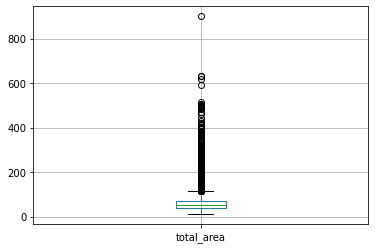

In [33]:
data.boxplot('total_area')
data[data['total_area'] > 250]['total_area'].count()

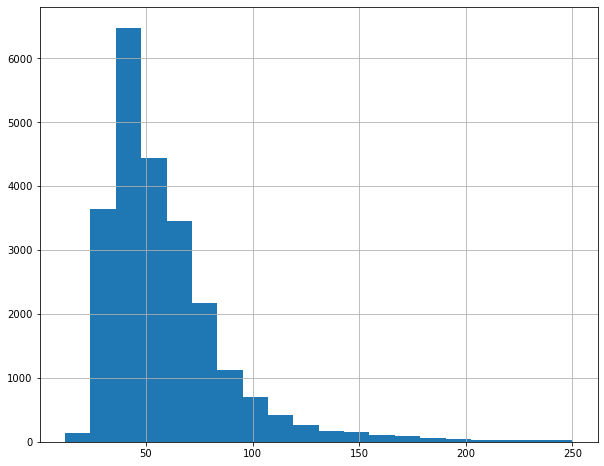

In [34]:
data = data.query('total_area <= 250')
data['total_area'].hist(bins=20, figsize=(10,8));

Видим график, распределение похоже на распределение Пуассона, что-то такое изначально и подразумевалось. Так же видим, что большее количество значений обладали площадью от 30 до 48 квадратных метров.

47

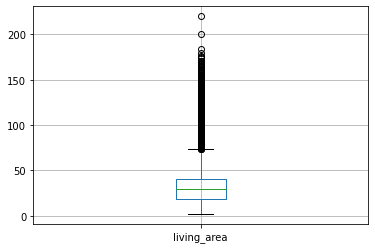

In [35]:
data.boxplot('living_area')
data[data['living_area'] > 150]['living_area'].count()

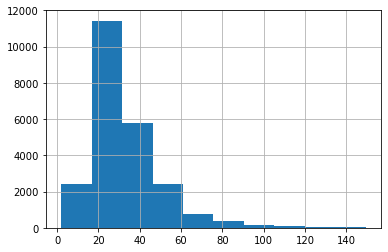

In [36]:
data = data.query('living_area < 150')
data['living_area'].hist();

Большая часть объектов имеет жилую площадь размером от 15 до 30 квадратных метров

103

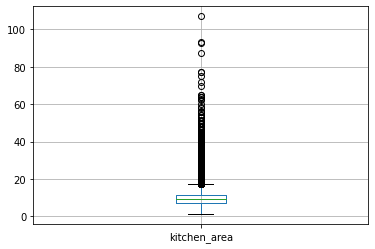

In [37]:
data.boxplot('kitchen_area')
data[data['kitchen_area'] > 40]['kitchen_area'].count()

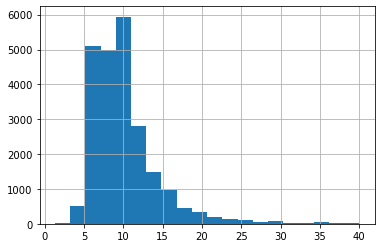

In [38]:
data = data.query('kitchen_area <= 40')
data['kitchen_area'].hist(bins=20);

Большая часть объектов имеет площадь кухни размером от 5 до 12 квадратных метров

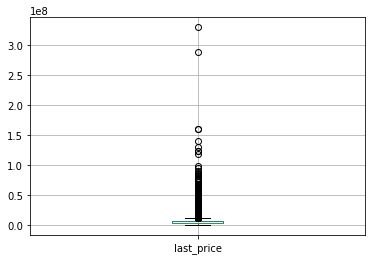

In [39]:
data.boxplot('last_price');

In [40]:
data['last_price'].describe()

count    2.338700e+04
mean     6.029830e+06
std      6.476630e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.600000e+06
75%      6.690000e+06
max      3.300000e+08
Name: last_price, dtype: float64

In [41]:
data[data['last_price'] > 20000000]['last_price'].count()
data = data.query('last_price <= 20000000')

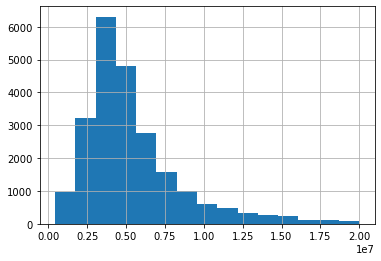

In [42]:
data['last_price'].hist(bins=15);

Вот здесь закрались огромные проблемы,так как что здесь, что в таблице выше мы можем увидеть, что в столбце 'last_price'. Потратив на эту проблему несколько часов, проблема решена не была, но было получено знание, что такое представление данных где-то называется научным, а расшифровывается как 1е8 = 1 * 10**8 

Это не помешало мне обработать стоблец, но представление данных не изменилось

In [43]:
display(data['rooms'].describe())
data[data['rooms'] > 5]['rooms'].count()

count    22872.000000
mean         2.004110
std          0.975849
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: rooms, dtype: float64

74

Здесь стоит отметить, что минимальное значение комнат = 0. Это может не являться ошибкой, так как это может быть какой-нибудь апартамент или крватира-студия

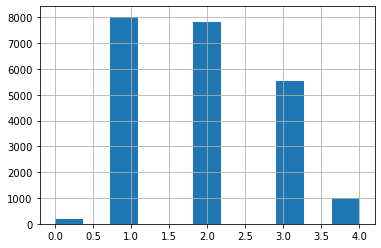

In [44]:
data = data.query('rooms < 5')
data['rooms'].hist(bins=11);

count    22577.000000
mean         2.720203
std          1.028268
min          1.000000
25%          2.550000
50%          2.700000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

87

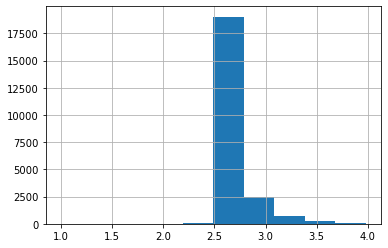

In [45]:
display(data['ceiling_height'].describe())
display(data[data['ceiling_height'] >= 4]['ceiling_height'].count())
data = data.query('ceiling_height < 4')
data['ceiling_height'].hist();

Видно, что большая часть объектов имеет потолки высотой от 2.6 метров до 2.7

count    22490.000000
mean         5.928324
std          4.912107
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

710

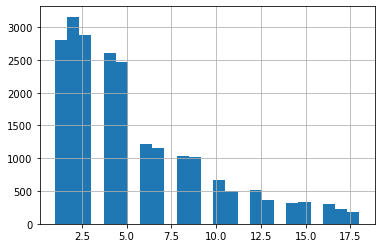

In [46]:
display(data['floor'].describe())
display(data[data['floor'] > 18]['floor'].count())
data = data[data['floor'] <= 18]
data['floor'].hist(bins=25);

Большая часть квартир была продана на 2 этаже

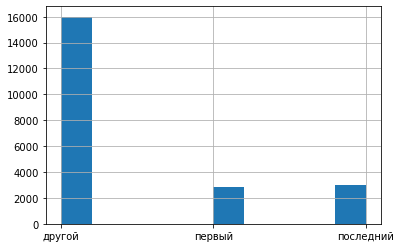

In [47]:
data['type_floor'].hist();

Квартиры на 1 или последних этажах - самые непопулярные, хотя последние чуть предпочтительнее

count    21780.000000
mean        10.376997
std          6.251085
min          1.000000
25%          5.000000
50%          9.000000
75%         15.000000
max         60.000000
Name: floors_total, dtype: float64

210

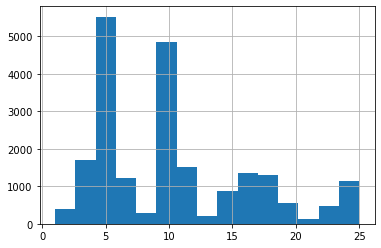

In [48]:
display(data['floors_total'].describe())
display(data[data['floors_total'] > 25]['floors_total'].count())
data = data.query('floors_total <= 25')
data['floors_total'].hist(bins=15);

Большая часть проданных объектов находились в пятиэтажных домах

count    21570.000000
mean     14221.205679
std       7559.661462
min        208.000000
25%      11325.000000
50%      13098.500000
75%      15276.750000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

413

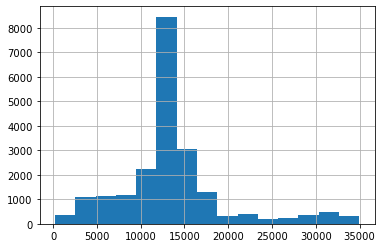

In [49]:
display(data['cityCenters_nearest'].describe())
display(data[data['cityCenters_nearest'] > 35000]['cityCenters_nearest'].count())
data = data.query('cityCenters_nearest <= 35000')
data['cityCenters_nearest'].hist(bins=15);

Большая часть объектов находится на расстоянии от 13 до 14 км до центра города

count    21157.000000
mean     27717.224890
std      10410.419482
min          0.000000
25%      20606.000000
50%      26726.000000
75%      33606.000000
max      61908.000000
Name: airports_nearest, dtype: float64

802

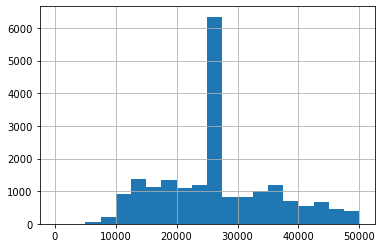

In [50]:
display(data['airports_nearest'].describe())
display(data[data['airports_nearest'] > 50000]['airports_nearest'].count())
data = data.query('airports_nearest <= 50000')
data['airports_nearest'].hist(bins=20);

Большая часть объектов находится в 27км от аэропорта

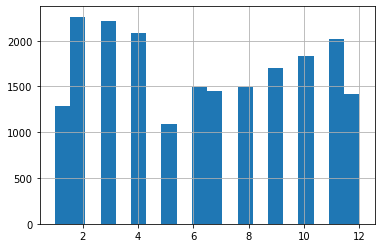

In [51]:
data['month'].hist(bins=20);

Большая часть объектов была продана в феврале-марте, меньшая - в мае

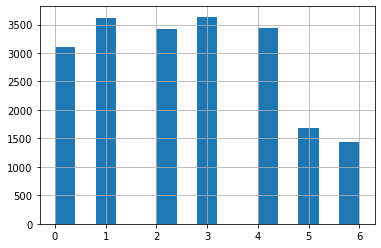

In [52]:
data['day'].hist(bins=15);

В выходные дни люди покупают меньше объектов недвижимости

count    17712.000000
mean       176.835535
std        215.715254
min          1.000000
25%         44.000000
50%         93.000000
75%        224.000000
max       1580.000000
Name: days_exposition, dtype: float64

66

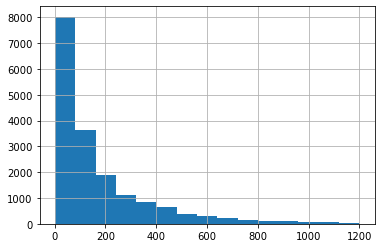

In [53]:
display(data['days_exposition'].describe())
display(data[data['days_exposition'] > 1200]['days_exposition'].count())
data = data.query('days_exposition <= 1200')
data['days_exposition'].hist(bins=15);

791

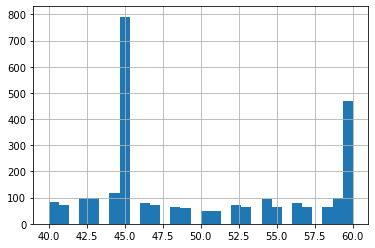

In [54]:
data['days_exposition'].hist(bins=30, range = (40, 60))
data['days_exposition'] = round(data['days_exposition']).astype(int)
data[data['days_exposition'] == 45]['days_exposition'].count()

Большая часть объектов продавалась от 44 до 221 дня. Соответственно, все продажи, совершенные раньше, чем за 44 дня, можно считать быстрыми, а продажи, дольше 221 дня - долгими. 

Замечен непонятный рост продаж на недвижимость на 45 день. Никакой зависимости выявлено не было, но можно предположить, что   эти аномалии очень похожи на техническую особенность самой платформы: вероятнее, в эти дни платформа автоматически убирает объявления, если пользователь его не продлил

In [55]:
pd.set_option('display.max_columns', 22)
display(data[data['days_exposition'] == 45].describe())
data[data['days_exposition'] == 45]['locality_name'].describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sq_meter,day,month,year,cityCenter_km
count,791.000000,7.910000e+02,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,129.000000,791.000000,160.00000,791.0,791.000000,791.000000,791.000000,791.000000,791.000000
mean,7.372946,3.108885e+06,45.759507,1.697851,2.624785,8.983565,27.898331,4.734513,8.845474,0.477876,26971.499368,14694.922250,0.216182,471.007752,0.268015,581.09375,45.0,70757.187370,2.675095,6.030341,2017.596713,14.638432
std,5.322865,1.330610e+06,13.046346,0.805665,0.156356,5.780016,8.282715,3.855663,2.108248,0.844463,7333.871431,5158.711411,0.546604,360.626202,0.598713,276.56816,0.0,28309.992933,1.875727,3.709596,0.701131,5.180366
min,0.000000,4.400000e+05,15.000000,0.000000,2.000000,1.000000,10.000000,1.000000,2.000000,0.000000,9143.000000,2659.000000,0.000000,10.000000,0.000000,19.00000,45.0,11000.000000,0.000000,1.000000,2016.000000,3.000000
25%,3.000000,2.250000e+06,36.000000,1.000000,2.500000,5.000000,20.000000,2.000000,8.000000,0.000000,26726.000000,13098.500000,0.000000,255.000000,0.000000,371.00000,45.0,48341.275660,1.000000,2.000000,2017.000000,13.000000
50%,7.000000,3.200000e+06,43.600000,2.000000,2.600000,6.000000,30.000000,4.000000,9.100000,0.000000,26726.000000,13098.500000,0.000000,431.000000,0.000000,589.50000,45.0,72413.793103,3.000000,6.000000,2018.000000,13.000000
75%,11.000000,3.855000e+06,53.750000,2.000000,2.700000,12.000000,30.000000,6.000000,9.100000,1.000000,26726.000000,13904.000000,0.000000,589.000000,0.000000,777.50000,45.0,92462.121212,4.000000,9.000000,2018.000000,14.000000
max,23.000000,1.440000e+07,103.300000,4.000000,3.900000,25.000000,69.000000,18.000000,23.600000,5.000000,49779.000000,34425.000000,3.000000,2711.000000,3.000000,1250.00000,45.0,144927.536232,6.000000,12.000000,2019.000000,34.000000


count                 791
unique                139
top       Санкт-Петербург
freq                  274
Name: locality_name, dtype: object

Поиски какой-либо зависимости велись очень тщательно, но все было тщетно.

### Изучение зависимости ряда факторов на стоимость объекта недвижимости

Здесь сначала идет влияние факторов отдельно, после - общий график "важности" каждого фактора.

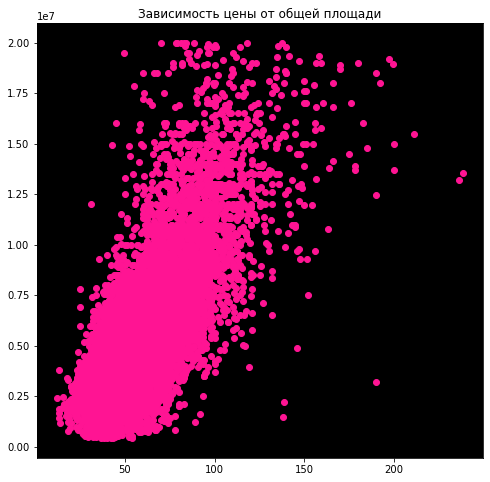

0.7518402191861143

In [56]:
x = data['total_area']    #  x - координаты точек
y = data['last_price']    #  y - координаты точек

fig, ax = plt.subplots()

ax.scatter(x, y,
           c = 'deeppink')    #  цвет точек

ax.set_facecolor('black')     #  цвет области Axes
ax.set_title('Зависимость цены от общей площади')     #  заголовок для Axes

fig.set_figwidth(8)     #  ширина и
fig.set_figheight(8)    #  высота "Figure"

plt.show()

data['total_area'].corr(data['last_price'])

Видна прямая зависимость цены от общей площади. При увеличении площади цена так же увиличивается в большинстве случаев.


Так же корреляция в 0.75 говорит нам о сильной взаимосвязи.Сам коэффициент корреляции положителен тогда и только тогда, когда и 𝑥𝑖 и 𝑦𝑖 лежат по одну сторону от своих средних значений.Это означает, что для того, чтобы коэффициент корреляции был положительным, 𝑥𝑖 и 𝑦𝑖 должны иметь тенденцию быть одновременно больше или одновременно меньше, чем их средние значения, тогда результирующая сумма в формуле ковариации будет положительна. Чем сильнее будут появляться эти тенденции, тем ближе окажется абсолютное значение коэффициента корреляции к единице.  

Именно поэтому имея корреляцию, равную 0.75, а так же график, на котором наглядно представлено распределение, можно сделать вывод о сильной взаимосвязи.

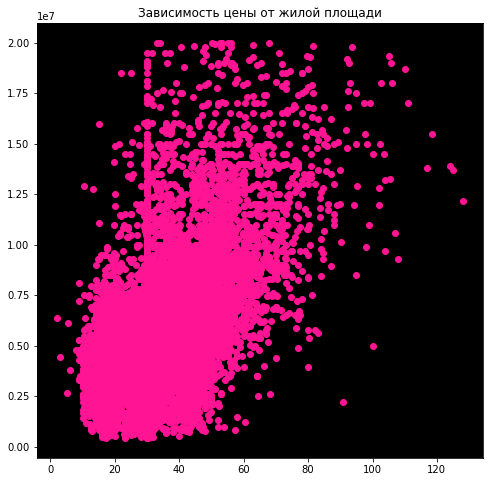

0.5983744500541165

In [57]:
x = data['living_area']    #  x - координаты точек
y = data['last_price']    #  y - координаты точек

fig, ax = plt.subplots()

ax.scatter(x, y,
           c = 'deeppink')    #  цвет точек

ax.set_facecolor('black')     #  цвет области Axes
ax.set_title('Зависимость цены от жилой площади')     #  заголовок для Axes

fig.set_figwidth(8)     #  ширина и
fig.set_figheight(8)    #  высота "Figure"

plt.show()

data['living_area'].corr(data['last_price'])

В основном, при увеличении жилой площади цена растет. Корреляция = 0.60, но так же говорит и о том, что взаимосвязь между общей площадью и ценой выше(или о том, что здесь присутствует более сильный разброс в данных, поэтому корреляция ниже, так как она показывает, насколько сильно зависят друг от друга средние значения факторов)

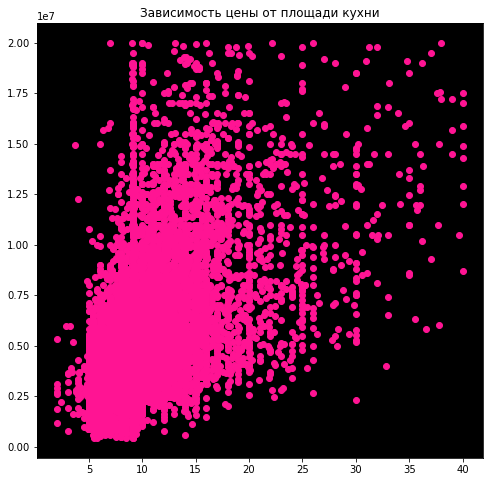

0.5352274115784286

In [58]:
x = data['kitchen_area']    #  x - координаты точек
y = data['last_price']    #  y - координаты точек

fig, ax = plt.subplots()

ax.scatter(x, y,
           c = 'deeppink')    #  цвет точек

ax.set_facecolor('black')     #  цвет области Axes
ax.set_title('Зависимость цены от площади кухни')     #  заголовок для Axes

fig.set_figwidth(8)     #  ширина и
fig.set_figheight(8)    #  высота "Figure"

plt.show()

data['kitchen_area'].corr(data['last_price'])

При увеличении площади кухни цена стремится к росту. Корреляция 0.53 говорит нам об этом, но так же говорит и о том, что она ниже взаимосвязей остальных площадей и цены.

Так же можно заметить, что имеется сильный разброс данных, начиная с площади кухни в 16-17 квадратных метров, что негативно вилияет на корреляцию, так как данные сильно удалены друг от друга, средние значения изменяются не так сильно, как это было бы, если бы в выборке участвовали кухни площадью от 5 до 15 метров.

0.46326474522452926

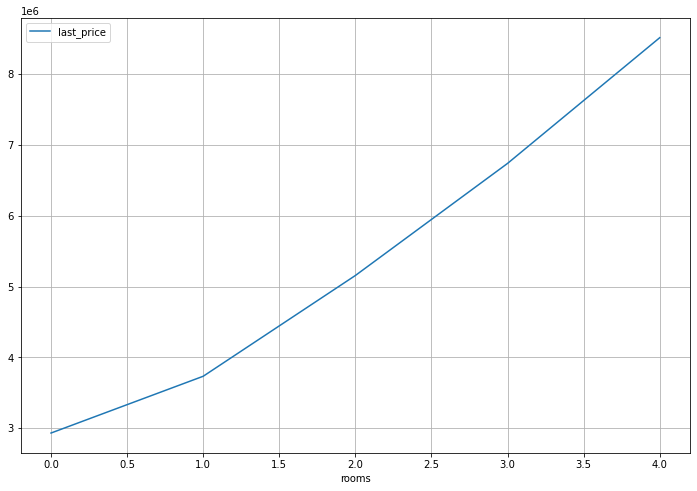

In [59]:
(
data
    .pivot_table(index='rooms', values='last_price')
    .plot(figsize=(12, 8), grid=True)
)
data['rooms'].corr(data['last_price'])

При увеличении количества комнат цена всегда растет. Корелляция в 46 процентов подтверждает это

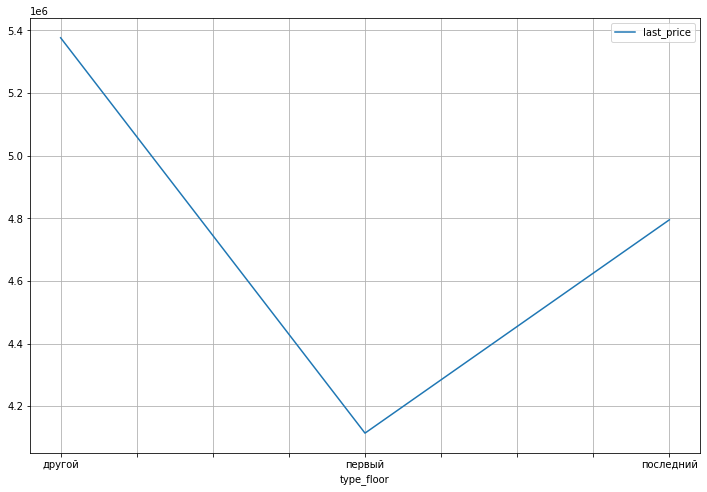

In [60]:
(
data
    .pivot_table(index='type_floor', values='last_price')
    .plot(figsize=(12, 8), grid=True)
);

Самые низкие цены на квартиры на 1 этаже, наиболее дорого оцениваются квартиры между 1 и последним этажом

-0.01225800520238851

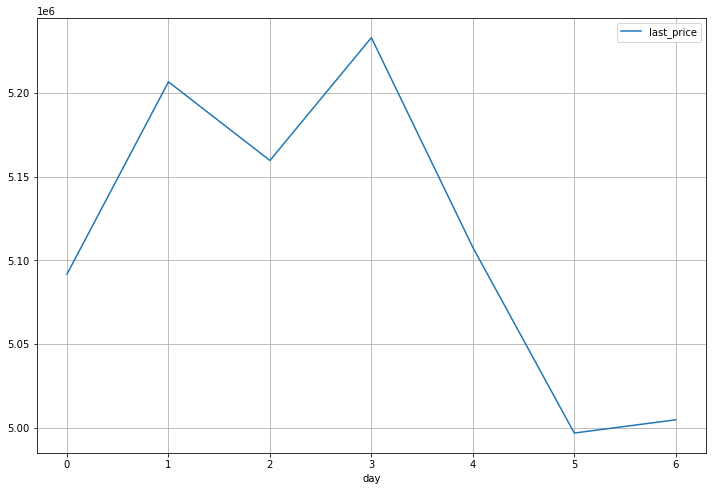

In [61]:
(
data
    .pivot_table(index='day', values='last_price')
    .plot(figsize=(12, 8), grid=True)
)

data['day'].corr(data['last_price'])

Замечена тенденция к возрастанию количества покупок, начиная с субботы, пик покупок приходится на среду, после чего начинается спад количества покупок до субботы. Корреляция говорит нам об отрицательной взаимосвязи на 1%, но она здесь не может отражать дстоверные данные, так как распределение имеет нелинейный характер. Так отрицательная связь говорит, что с увеличением дня недели стоимость купленных объектов падает, но на графике мы можем увидеть, что она сначала растет, доходит до пика в четверг, а потом резко падает до субботы, и все начинается заново.

0.007920628556323991

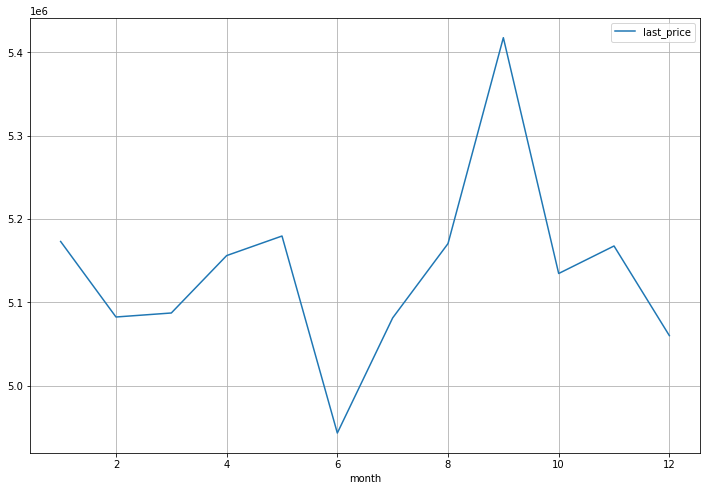

In [62]:
(
data
    .pivot_table(index='month', values='last_price')
    .plot(figsize=(12, 8), grid=True)
)
data['month'].corr(data['last_price'])

Наиболее дорогую недвижимость люди покупают в сентябре, наименее дорогую - в июне. 

Корреляция здесь аналогично не может сообщать достоверную информацию, так как мы здесь видим аномально высокие и низкие значения, которые сбивают корреляцию(хотя если график был бы разделен на 2 части по полугодиям, сначала была бы отрицательная корреляция, что говорило бы, что первые полгода цена падает, а во второй части - положительная).

-0.051730568163470256

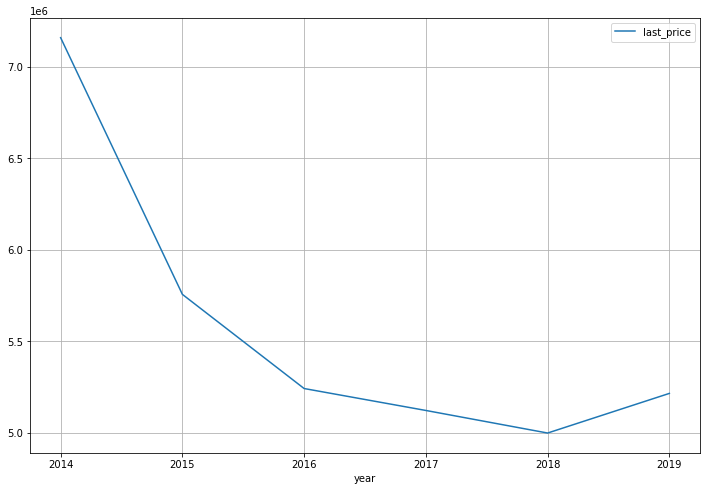

In [63]:
(
data
    .pivot_table(index='year', values='last_price')
    .plot(figsize=(12, 8), grid=True)
)
data['year'].corr(data['last_price'])

Наблюдается тенденция к уменьшению стоимости покупаемой недвижимости с 2014 по 2018 год(о чем и свидетельствует отрицательная корреляция), после него идет относительное увеличение стоимости. 

Стоит заметить, что хоть корреляция и показывает, что связь отрицательная, но  это значение столь мало, что им можно пренебречь, если не смотреть на график. На графике же видно, что есть четкая зависимость, но поскольку график нелинеен, корреляция не может это показать. Если мне не изменяет память, ковариация здесь могла бы помочь и показать, что корреляция показывает данные, не отражающие реальную ситуацию, но общая тенденция прекрасно видна на графике

-0.10274929136718931

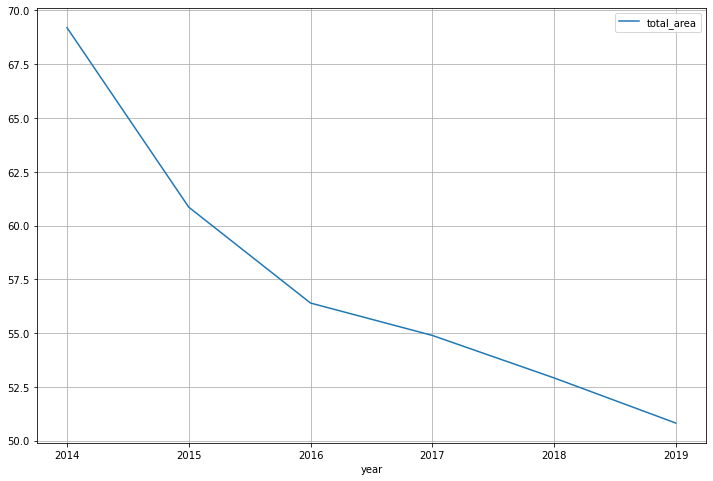

In [64]:
(
data
    .pivot_table(index='year', values='total_area')
    .plot(figsize=(12, 8), grid=True)
)

data['year'].corr(data['total_area']) 

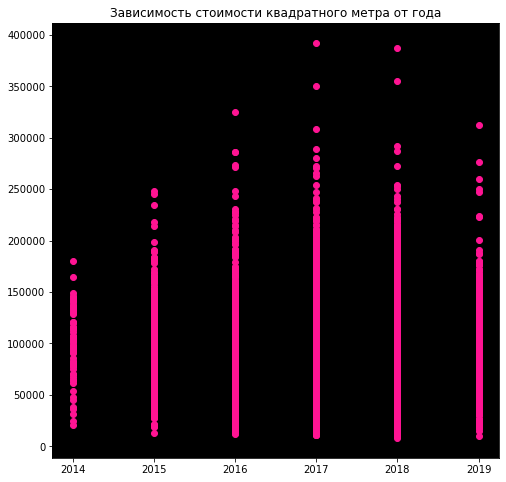

0.0420321725831904

In [65]:
x = data['year']    #  x - координаты точек
y = data['price_sq_meter']    #  y - координаты точек

fig, ax = plt.subplots()

ax.scatter(x, y,
           c = 'deeppink')    #  цвет точек

ax.set_facecolor('black')     #  цвет области Axes
ax.set_title('Зависимость стоимости квадратного метра от года')     #  заголовок для Axes

fig.set_figwidth(8)     #  ширина и
fig.set_figheight(8)    #  высота "Figure"

plt.show()
data['year'].corr(data['price_sq_meter'])

Получается, что количество проданной общей площади падает каждый год, а стоимость квадратного метра среднестатистически растет(но в 2019 году падает). Можно предположить, что уменьшение общей стоимости на 2 графиках выше свидетельствует не об удешевлении недвижимости, а о меньшем количестве ее приобретений.

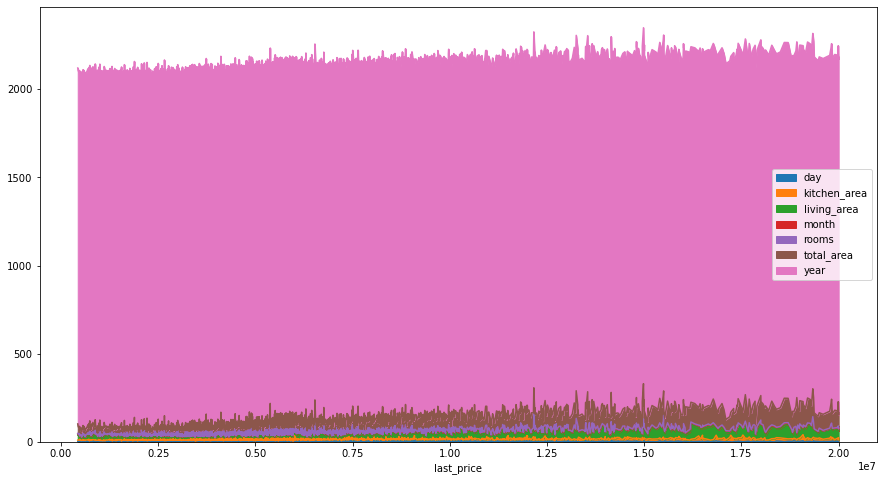

In [66]:
(data
    .pivot_table(
        index='last_price', 
        values=['total_area', 'rooms', 'living_area', 'kitchen_area', 'type_floor', 'day', 'month', 'year'])
     .plot(kind='area', figsize=(15,8))
);

Видно, что наибольшее влияние на цену оказывает год, на 2 месте расположилась общая площадь. Меньше всех влияет на продажу день и месяц

In [67]:
top_cities = data.groupby('locality_name')['total_images'].count().sort_values( ascending=False)
top_cities.head(10) #Узнали топ-10 населенных пунктов

locality_name
Санкт-Петербург    11837
посёлок Мурино       437
посёлок Шушары       373
Всеволожск           334
Колпино              300
Пушкин               292
Гатчина              266
деревня Кудрово      265
Выборг               205
Красное Село         147
Name: total_images, dtype: int64

In [68]:
def mean_price_sq_meter(cities): #Узнаем среднюю стоимость квадратного метра в наиболее популярных населенных пунктах
    for city in cities:
        print('средняя цена квадратного метра:', city, '=',data[data['locality_name'] == city]['price_sq_meter'].mean())

cities = ['Санкт-Петербург', 'посёлок Мурино',  'посёлок Шушары',  'Всеволожск',  'Пушкин', 'Колпино', 
          'Гатчина', 'деревня Кудрово',  'Выборг', 'Красное Село']

mean_price_sq_meter(cities) 

средняя цена квадратного метра: Санкт-Петербург = 107018.69732426648
средняя цена квадратного метра: посёлок Мурино = 85526.83130127066
средняя цена квадратного метра: посёлок Шушары = 78025.88040639239
средняя цена квадратного метра: Всеволожск = 66707.47851840255
средняя цена квадратного метра: Пушкин = 101021.51295221633
средняя цена квадратного метра: Колпино = 74754.45853601955
средняя цена квадратного метра: Гатчина = 67994.75192487762
средняя цена квадратного метра: деревня Кудрово = 92839.16782216028
средняя цена квадратного метра: Выборг = 57159.32032265834
средняя цена квадратного метра: Красное Село = 72225.27900008108


Самая высокая стоимость квадратного метра в Санкт-Петербурге, самая низкая - в Выборге

In [69]:
display(data[data['locality_name'] == 'Санкт-Петербург'].groupby('cityCenter_km')['last_price'].mean())

cityCenter_km
0     8.798000e+06
1     9.940058e+06
2     9.060346e+06
3     8.002040e+06
4     8.686337e+06
5     8.838751e+06
6     8.063780e+06
7     7.648618e+06
8     7.424567e+06
9     6.091022e+06
10    5.726005e+06
11    5.623234e+06
12    5.468501e+06
13    5.728099e+06
14    5.308972e+06
15    5.169474e+06
16    4.946892e+06
17    4.953464e+06
18    4.491020e+06
19    4.696500e+06
20    4.466000e+06
21    5.215749e+06
22    4.980636e+06
23    4.617797e+06
24    3.694714e+06
25    4.144038e+06
26    3.914994e+06
27    8.300000e+06
28    5.026429e+06
29    4.114000e+06
Name: last_price, dtype: float64

-0.32073255022641756

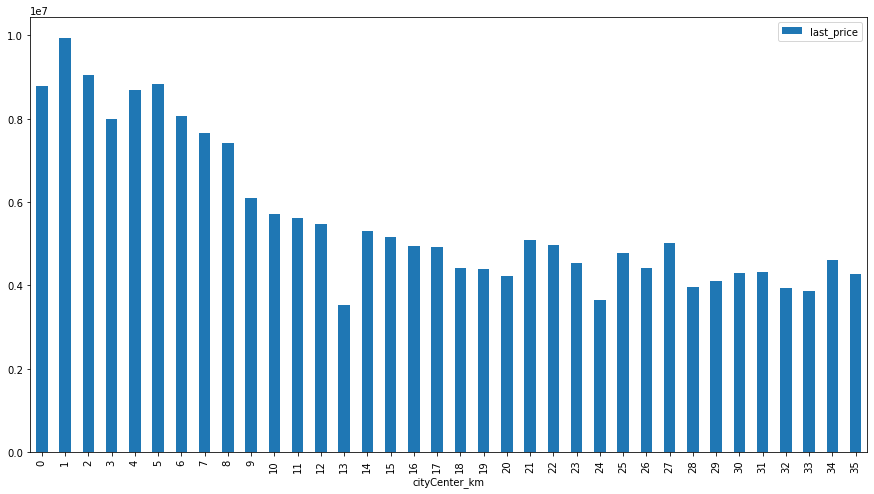

In [70]:
(data
    .pivot_table(
        index='cityCenter_km', 
        values='last_price')
     .plot(kind='bar', figsize=(15,8))
)

data['last_price'].corr(data['cityCenter_km'])

самая дорогая недвижимость находится в пределах 2 километров от центра города, далее присутствует тенденция к падению стоимости, что иллюстрирует график. Так же это подтверждает отрицательный коэффициент корелляции

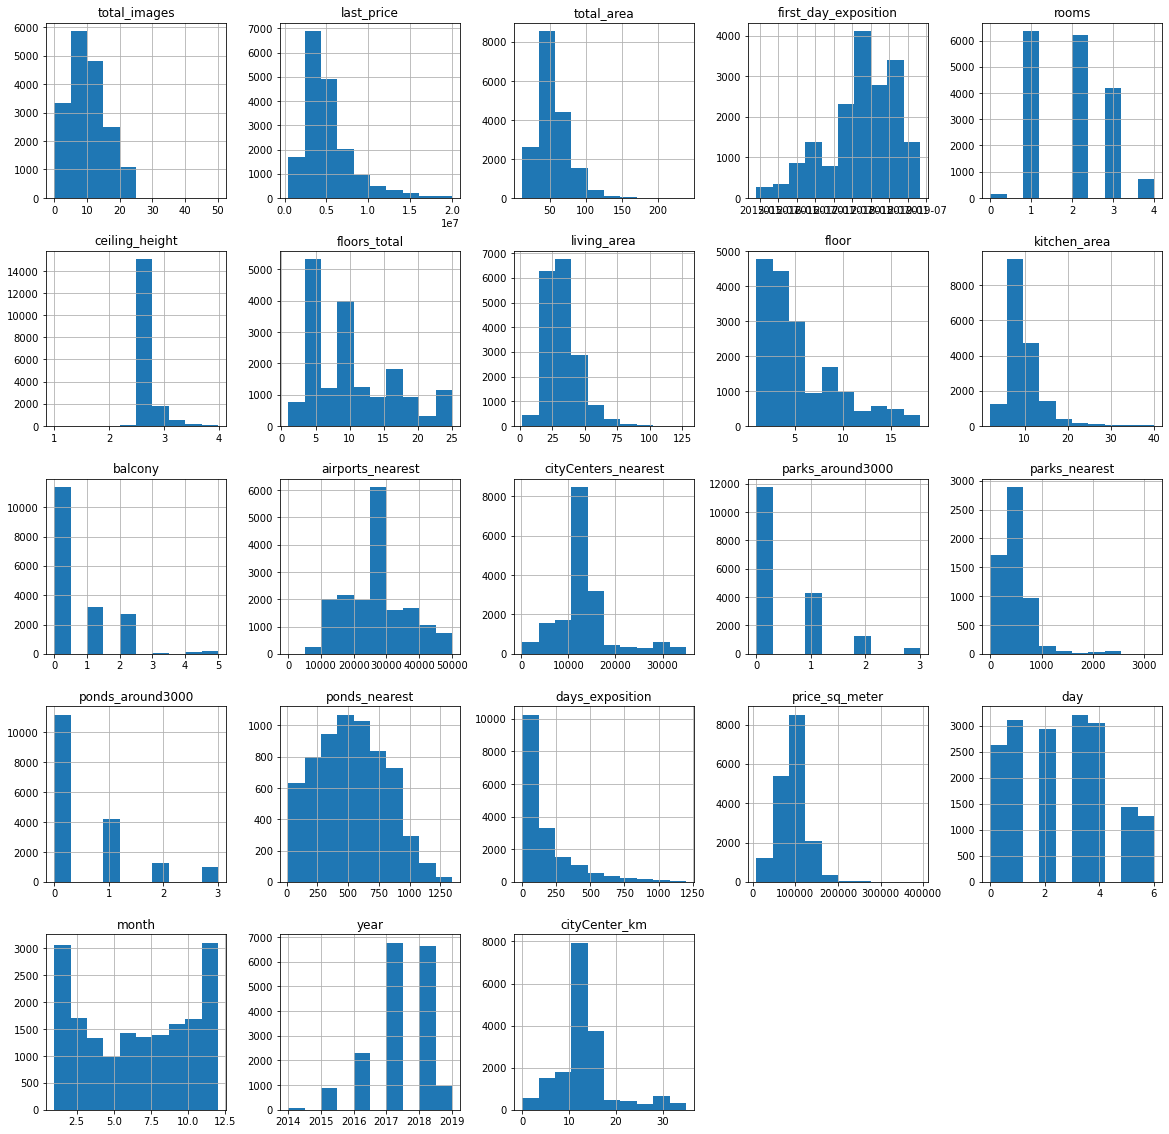

In [71]:
data.hist(figsize = (20,20));

В начале мы строили гистограммы по "сырым" данным, теперь - по обработанным, можно увидеть небольшие изменения.

## Общий вывод

В процессе работы были выявлены и исправлены, где это возможно, исходные данные(об этом ниже). Были исправлены неточности в типах данных, уточнены сведения из имеющихся данных(например, день недели или месяц) и добавлены в датафрейм. Так же были обработаны аномальные значения и выбросы, найдены различные закономерности, построены соответствующие графики и каждый из них был прокомментирован. Помимо этого, рядом с графиками, на которых видна зависимость одного фактора от другого, был посчитан коэффициент корреляции, свидетельствующий о наличии или отсутствии взаимосвязи(хотя он не совсем точен, так как больше предназначается для линейных данных, но это опустим).

Во - первых, в исходных данных есть пропущенные данные, которые статистически важны, поэтому их невозможно заполнить каким-либо значением. Это столбцы "ponds_nearest", "parks_nearest" и "days_exposition". Требуется проверить исходные данные и заполнить пропуски.

Во-вторых, были выявлены следующие закономерности:

1. Цена прямо пропорциональна следующим факторам: **общая площадь, жилая площадь, площади кухни и количество комнат**. При их увеличении есть тенденция к увеличению цены недвижимости.

2. Количество покупок зависит от дня недели и месяца.  Так есть тенденция к возрастанию количества покупок, начиная с субботы, пик покупок приходится на среду, после чего начинается спад количества покупок. В выходные дни люди покупают гораздо меньше объектов недвижимости. Большая часть объектов была продана в феврале-марте, а меньшая - в мае. Наиболее дорогую недвижимость люди покупают в сентябре, наименее дорогую - в июне. Так же наблюдается тенденция к уменьшению стоимости покупаемой недвижимости с 2014 по 2018 год, после него идет увеличение стоимости. 

3. Характеристики наиболее популярных объектов таковы: **общая площадь** - от 30 до 48 квадратных метров, **жилая площадь** - от 15 до 30 квадратных метров, **площадь кухни** - от 5 до 12 квадратных метров, **количество комнат** - 1-2,  **высота потолков** - от 2.6 до 2.7 метра, **расстояние до центра города** - 13-14 км, **расстояние до аэоропорта** - 27 км. 

4. Большая часть проданных объектов находилась в пятиэтажных домах, большая часть квартир была продана на 2 этаже. Большинство объектов продавалось от 44 до 221 дня. Наименее популярны первые этажи, они же самые дешевые; наиболее популярные и самые дорогие - этажи между первым и последним.

5. Самая высокая стоимость квадратного метра в Санкт-Петербурге(107019), самая низкая - в Выборге(57159). Самая дорогая недвижимость находится в пределах 2 километров от центра города, далее присутствует тенденция к падению стоимости

6. Влияния на цену оказывают следующие факторы(указаны по **уменьшению** влияния): год, общая площадь, комнаты, жилая площадь, площадь кухни, день и месяц. 